In [2]:
#!pip install spectral-cube
#!pip install pvextractor 
#!pip install aplpy
import matplotlib.pyplot as plt
import numpy as np
from scipy import*
import scipy.ndimage as nd
import matplotlib 
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from scipy import stats
import aplpy
from matplotlib import*
from astropy.convolution import Kernel1D
#from astropy.convolution import Box1DKernela
from astropy import units as u
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import* # SpectralCube 
from spectral_cube import Projection 
import scipy.ndimage as nd
from pvextractor import extract_pv_slice
from pvextractor import Path
from scipy import optimize

from sympy import nsolve
from scipy.optimize import fsolve 
from scipy.constants import*
from astropy import constants as con
from astropy import units as u

import matplotlib.mlab as mlab
from astropy.convolution import Kernel1D
from astropy.table import Table
from astropy.wcs import WCS
from astropy.wcs import utils 
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.table import QTable
#from yt.mods import ColorTransferFunction, write_bitmap
#from astropy import yt
import warnings
from astropy.io import fits
import pandas as pd
import seaborn as sns
from astropy.table import vstack, hstack, join

from astropy import units as u
from astropy.visualization.wcsaxes import Quadrangle

# Import DataSci packages and classes >>>>>>>>>>>>>>>>>>

import pandas as pd
import numpy as np

# We'll use this later
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# This is new, it will allow us to interact with
# 3d plots in the notebook
from mpl_toolkits.mplot3d import Axes3D

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")


In [4]:
import os
working_directory = os.getcwd()
print(working_directory)

/Volumes/GoogleDrive/My Drive/0.Work/RESEARCH_INFO/Research_2021/PilotSurvey_Newfields/Large-sample-outflows-in-CygX-and-ML-methods/notebooks


In [3]:
#############################################################################################################
## >>>>>>>>>>>>>>>>> Alternative way of uploading and reading files >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#############################################################################################################

filepath = '/Volumes/GoogleDrive/My Drive/0.Work/RESEARCH_INFO/Research_2021/PilotSurvey_Newfields/Large-sample-outflows-in-CygX-and-ML-methods/'
#filepath = "C:\\Users\\Uber-PC\\Google Drive\\0.Work\\CourseworkStudyMaterial\\Data_Science\\Fall2021\\Erdos_GitHub\\fall-2021\\python prep\\Practice Problems\\" # <<<< this only works with Jupyter Notebook 
           #"C:\Users\Uber-PC\Google Drive\0.Work\CourseworkStudyMaterial\Data_Science\Fall2021\Erdos_GitHub\fall-2021\python prep\Practice Problems\random_walk.csv"

##########################################################################################################################

#kryu_list = QTable.read(filepath + '/data/asu (1).fit') # original Kryukova survey 
#proto = QTable.read(filepath + '/data/cygx_pilot_protostars(Kry).fit')
#wu = QTable.read(filepath + '/data/WuTable.fit')
#outflowsCloud = QTable.read(filepath + '/data/outflowsClouds_output.fit')
#cygX_init_newfields = QTable.read(filepath+'/data/table_newfields_input.fit')
#cygX_init_pilot_1_5kpcA =  QTable.read(filepath + '/data/cygX_pilot_1.5kpc_A_input.fit')
#pilotL = QTable.read(filepath + '/data/cygxPilot_proto.fits')
#cygx_combined_out = pd.read_csv(filepath + '/data/cygx_combined_out.csv').round({'RAJ2000':3, 'DecJ2000':3})

outflows = QTable.read(filepath + '/data/outflowsCloudsJCMT_output.fit')
outflowsF = QTable.read(filepath + '/data/outflowsCloudsJCMT_F.fit')
#proto_0 = QTable.read(filepath + '/data/cygx_class0.fits')
#proto_1 = QTable.read(filepath + '/data/cygx_class1.fits')

# read coordinates tables 
#of_newfields = QTable.read(filepath + '/data/table_newfields_input.fit')
#of_cygrift = QTable.read(filepath + '/data/cygX_pilot_cygrift0.65kpc_outout.fit')
#of_W75 = QTable.read(filepath + '/data/cygX_pilot_W75_outout.fit')
#of_DR21 = QTable.read(filepath + '/data/cygX_pilot_DR21_outout.fit')

cygX0 = SpectralCube.read(filepath + '/data/cygx_cobig_small.fits')
#cygX_pilot = SpectralCube.read(filepath +'/data/cygX_pilot_km.fits')
#cygx21cm = SpectralCube.read(filepath + '/data/cygx.c21_reprj.fits')
#co =  SpectralCube.read(filepath + '/data/co_spec_cropped.fits') #cube_cobig_km
#co_mom0 = (np.expand_dims(co.moment(order=0, axis=0), axis=0))
#cygx_mom0 = SpectralCube.read(filepath + '/data/cygx_mom0.fits')


INFO: Auto-setting vmin to -2.565e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.720e+01 [aplpy.core]


<Figure size 1296x1152 with 0 Axes>

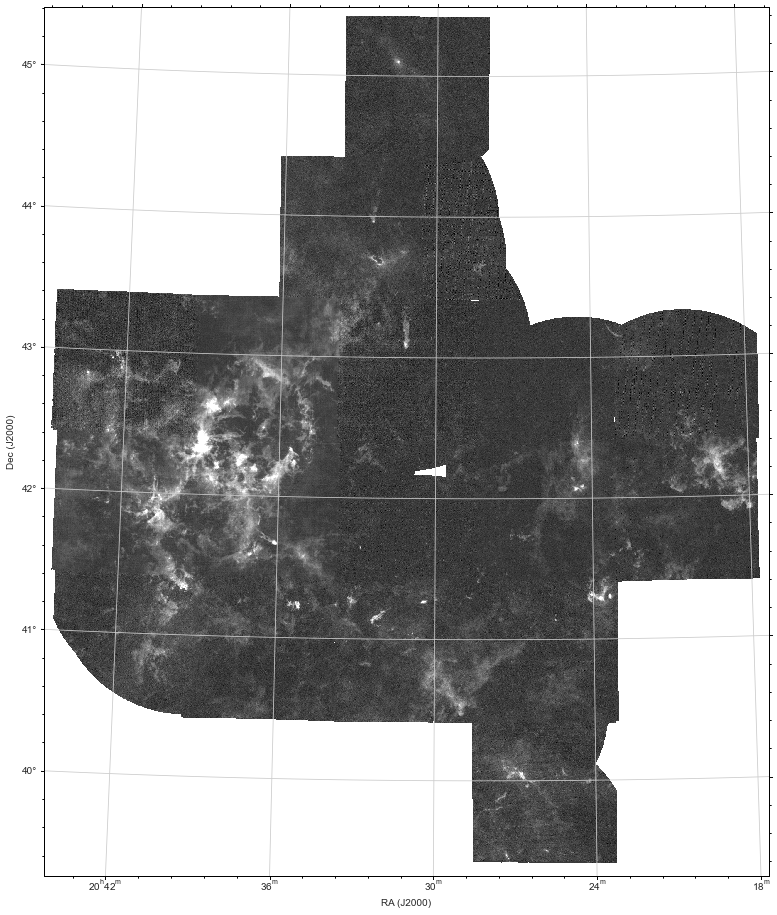

In [4]:
#######################################################################################################
#######################                                             ###################################
#>>>>>>>>>>>>>>>>>>>>>> Clouds with set length scales using 2D mask >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#######################                                             ###################################
#######################################################################################################

scale_factor = 5
from scipy import ndimage
cygX0 = cygX0.with_spectral_unit(u.km/u.s)
cloud_dummy = np.ones_like(cygX0[0,:,:])

# Transform world coordinates to pixel coordinates for all outflow locations 
# change values on such coordinate from 1 to 0
for z in range(0,83):
    xw = outflows[z]['RAJ2000']
    yw = outflows[z]['DecJ2000']
    xpix, ypix, _ = cygX0.wcs.wcs_world2pix(xw, yw, 0, 0)
  #print('outflow',z,xpix, ypix)
    try:
        cloud_dummy[int(ypix), int(xpix)] = 0
    except IndexError:
        print('outflow', z, 'raises index error')
        pass


# Apply EDT and get distance array 
cloud_EDT, inds = ndimage.distance_transform_edt(np.array((cloud_dummy)),return_indices=True)
cdelt = cygX0.wcs.celestial.wcs.get_cdelt()

length_scale_kpc = scale_factor * 0.004686572 * u.kpc # a temp value for testing the code 
length_scale_pix = ((length_scale_kpc / (np.median(outflows['Distance'])))*u.radian).to(u.deg) # in Radian
length_scale_pix = np.round(length_scale_pix / (np.abs(cdelt[0]) * u.deg), 0)

# create a mask based on length scale and apply the mask on data cube 
from astropy import units as u
from spectral_cube import BooleanArrayMask
#mask = BooleanArrayMask(mask=np.where(cloud_EDT<length_scale_pix,cloud_EDT, 0), wcs=cygX0.wcs)  
mask2d = cloud_EDT < length_scale_pix ###### CHANGE LENGTH HERE 
#mask3d = BooleanArrayMask(mask=np.ones(cygX0.shape[0])[:, np.newaxis, np.newaxis] * mask2d[np.newaxis, : ,:], wcs=cygX0.wcs)
mask1 = BooleanArrayMask(mask=np.ones(cygX0.shape[0], dtype=bool)[:, np.newaxis, np.newaxis] * mask2d[np.newaxis, : ,:], wcs=cygX0.wcs)
cygX0_masked = cygX0.with_mask(mask1)


#cygX0_mom0_along_z = cygX0.moment(order=0, axis=0)  


cygX0_masked_mom0_along_z = cygX0_masked.moment(order=0, axis=0) 
plt.figure(figsize=(18, 16))
f = aplpy.FITSFigure(cygX0_masked_mom0_along_z.hdu,figsize=(18, 16))
#.show_colorscale()

f.show_grayscale()

In [5]:
%%time 
warnings.filterwarnings('ignore', category=UserWarning, append=True)

### >>>>>> CLOUD ENERGY FOR MASKED CLOUD REGION >>>>>>>>>>>>>>>>>> 

cloud = cygX0_masked.spectral_slab(-20 * u.km / u.s, +20 * u.km / u.s)
#cloud = cygX0.spectral_slab(-20 * u.km / u.s, +20 * u.km / u.s)
cloud.allow_huge_operations=True
Tpeak = cloud.max(axis=0) * u.K   # <<<<--- change to u.K for big cube --->>>>

#Tpeak_=Tpeak.copy()
#f = aplpy.FITSFigure(Tpeak_.hdu)
#f.show_colorscale()

from cygFn import f, length, Jnu, G, Quad
#cloud = cygX0_masked.spectral_slab(-20 * u.km / u.s, +20 * u.km / u.s)
cloudshape = cloud[0].shape # x, y axes dimensions 
vaxis=cloud.spectral_axis.value 
                   
v0array = np.zeros(cloudshape)
sig0array = np.zeros(cloudshape)
amparray= np.zeros(cloudshape)



print('STEP 1')
from astropy import units as u
              
## >>>>>>>>>>>>>  MAKE A FUNCTION >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#cloud.allow_huge_operations=True
#Tpeak = cloud.max(axis=0) * u.K   # <<<<--- change to u.K for big cube --->>>>
nu = 330.588 * u.GHz
Tbg = 2.73 * u.K
Aul = 6.038e-7 / u.s
B0 = 54891.42 * u.MHz
E3 = 30 * u.K
Tex = ((con.h * nu / con.k_B)
                      / np.log(1 + con.h * nu
                              / (con.k_B * (Tpeak + Jnu(Tbg, nu=nu)))))
Tex = Tex.to(u.K)
co13cloud = np.zeros_like(cloud)

DeltaNu = np.abs((vaxis[1] - vaxis[0]) * u.km / u.s/ con.c * nu).to(u.Hz)
DeltaV = np.abs((vaxis[1] - vaxis[0]) * u.km/u.s)

log_co13cloud = 2.074571 * np.log10(cloud) - 2.699635
co13cloud=10**log_co13cloud

tau13dnu = co13cloud * DeltaV

N13co = (8 * np.pi * nu**3 / con.c**3 / Aul
/(np.exp(con.h * nu / con.k_B / Tex) - 1) * tau13dnu
)
Qrot = con.k_B * Tex / (con.h * B0) * np.exp(con.h * B0
/ (3 * con.k_B * Tex))

N13coTot = Qrot / 7 * np.exp(E3 / Tex) * N13co # g_u=7m for u=3, l=2 transition Qrot

NH2 = (7.5e5 * N13coTot).to(u.cm**(-2))
ang_width = 1 * 14.6 * u.arcsec
cdelt = utils.proj_plane_pixel_scales(cygX0.wcs)
width = (ang_width*0.5 / (cdelt[0] * u.deg)).to(u.dimensionless_unscaled).value
apix = np.prod(
np.abs(np.array([width, 1])
* (cloud.wcs.celestial.wcs.get_cdelt())
/ 180 * np.pi * np.median(outflows['Distance']).value)) * u.kpc**2
Mass = (NH2 * con.m_n * 2.32 * apix).to(u.solMass)
print('Mass dimensions:',Mass.shape)
print('STEP 2')

vpeak=np.ones(cloudshape) * u.km/u.s
sigma=np.ones(cloudshape)
vaxis=cloud.spectral_axis.value
try:
    ai = np.nanargmax(cloud, axis=0)
    vpeak = vaxis[ai] * u.km/u.s
except ValueError :
    pass
print('STEP 2a')


hf = Tpeak.value/2
slice_unmasked = cloud.unmasked_data[:,:,:]
#velo, dec, ra = cloud.world[:]
print('STEP 3')

mask = slice_unmasked > hf
border = np.logical_or(mask * np.roll(~mask, 1,axis=0),mask * np.roll(~mask, -1, axis=0))
velo_ = cloud.spectral_axis
velo = velo_[:, np.newaxis, np.newaxis] * np.ones(cloud[0,:,:].shape)[np.newaxis,:,:]
#velo, dec, ra = cloud.world[:]
vcube = velo * 1
vcube[~border] = np.nan
dvcube_pos = vcube - vpeak[np.newaxis, :, :] #* u.km/u.s
dvcube_neg = -1 * dvcube_pos
dvcube_neg[dvcube_neg < 0] = np.nan
dvcube_pos[dvcube_pos < 0] = np.nan
dv_pos = np.nanmin(dvcube_pos, axis=0)
dv_neg = np.nanmin(dvcube_neg, axis=0)
HWHM = np.minimum(dv_pos, dv_neg)
sigma = HWHM/((2*np.log(2))**0.5)
print('STEP 4')

n=int(vaxis.shape[0]/2) #this integer must be less than spectral pixel number
Energy = np.zeros(shape=(n, cloudshape[0],cloudshape[1]))*u.erg
vcen = np.zeros(shape=(n, cloudshape[0],cloudshape[1]))
vcentr = np.zeros(cloudshape) # dim should be equal to the number of spatial pixels along the mass pv slice

l1 = vpeak - 3*sigma # <<<<<<<<<<<<<<<<<<<<<<<<  SHOULD IT BE 2 ??? YES THIS RANGE IS JUST USED TO FIND E_MIN AT WHAT VEL
u1 = vpeak + 3*sigma
vcen = np.linspace(l1,u1,n) # half of spectral pixels
print('STEP 4a')

##>>>>>>>>>>>>  THIS STEP TAKES 20 MIN >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
for indx in range(0, n): 
    voff = vcen[indx, :, :] - (vaxis[:, np.newaxis, np.newaxis])*u.km/u.s#2n values for each of vcen VALUES
    Energy[indx,:,:] = (np.nansum(Mass*voff**2,axis=0)).to(u.erg)#SUM OVER 2n values along z axis   
    #vcentr = vcen[np.nanargmin(Energy[indx,:,:])]
print('STEP 5')
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

vcentr = vcen[np.nanargmin(Energy)] # minimizing over n-values along z axis for each spatial pixel
from astropy import units as u
#energyC = np.zeros(cloudshape) * u.solMass * (u.km/u.s)**2
turbLum = np.zeros(cloudshape) * u.solLum
print('STEP 5a') 

vaxis_new = vaxis[:, np.newaxis, np.newaxis]*u.km/u.s
voff = vcentr-vaxis_new
# create a mask for z-axis 
idxC = (vaxis_new > vcentr - 3*sigma) & (vaxis_new < vcentr + 3*sigma)
#energyC = (1/2) * np.nansum(Mass[idxC] * voff[idxC]**2)
#turbLum = np.nansum(Mass[idxC] * np.abs(voff[idxC])**3)

voff_new = voff.copy()
Mass_new = Mass.copy() 
voff_new[~idxC] = np.nan
Mass_new[~idxC] = np.nan
turbLum = np.nansum((Mass_new * np.abs(voff_new)**3), axis=0)
print('STEP 6')

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>> RUN AGAIN 
#angle = (cloudshape[0] * (cdelt[0] * u.deg)).to(u.arcmin)
#L = (((cloudshape[0] * (cdelt[0] * u.deg)).to(u.rad)) /(1*u.rad)).to(u.dimensionless_unscaled) * np.median(outflows['Distance'])     #<<<<<<<<<<< size of cloud <<<<<<<<<<<<<<<<<<<<<<<<<<<<<
#energy_cloud = energyC.sum().to(u.erg)/(1e44*u.erg) # units of 1e44*u.erg *u.solMass*u.km**2/u.s**2)
#L = length_scale_kpc
#lum_cloud = ((3/2) * turbLum.sum()/L).to(u.solLum)# L is the radius of associated cloud = R
print('STEP 7')
#print(lum_cloud, turbLum.sum())

# save numpy array as npy file
from numpy import asarray
from numpy import save
# define data
np.array(turbLum)
# save to npy file
save(filepath + '/data/turbLum.npy', np.array(turbLum))

/Users/sdeb/opt/anaconda3/lib/python3.9/site-packages/spectral_cube/spectral_cube.py:539: RuntimeWarning: All-NaN slice encountered
  result = function(np.dstack((result, plane)), axis=2, **kwargs)


STEP 1


/Users/sdeb/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
<timed exec>:44: RuntimeWarning: invalid value encountered in log10


Mass dimensions: (95, 2966, 2471)
STEP 2
STEP 2a
STEP 3


<__array_function__ internals>:5: RuntimeWarning: All-NaN axis encountered


STEP 4
STEP 4a
STEP 5
STEP 5a
STEP 6
STEP 7
CPU times: user 10min 50s, sys: 20min 35s, total: 31min 26s
Wall time: 35min 26s


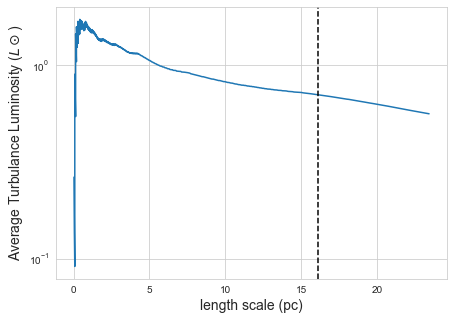

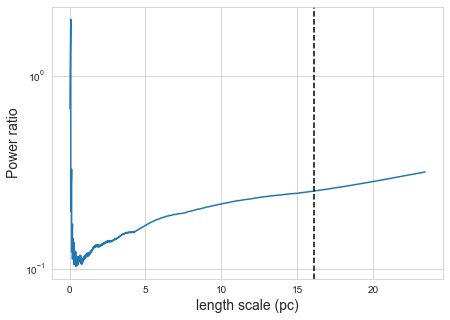

In [53]:
# CALCULATE MASKED LUM_CLOUD IN A LOOP AS A FUNCTION OF LENGTH SCALE 
length = []
Lum_turb = []
power = []

Lum_mech_tot = outflowsF['L_mech'].nansum()
cygX0_mom0_along_z = cygX0.moment(order=0, axis=0)

# power vs length curve should flattenn at length = length_crit
length_crit = (((((cygX0.shape[1]*cygX0.shape[2]/84)**0.5) * (cdelt[0] * u.deg)).to(u.rad)) /(1*u.rad)).to(u.dimensionless_unscaled) * np.median(outflows['Distance'])
length_crit = length_crit.to(u.pc)
ls_pc = (0.004686572 * u.kpc).to(u.pc)
factor_set = np.geomspace(0.006, 5, 1000)

for scale_factor in factor_set:#[0.006, 0.007, 0.008,0.01,0.012,0.015,0.017,0.0175,0.018,0.019,0.02,0.03,0.04,0.05,0.06,0.07,0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.1,4.25,4.5,4.75,5]:#,1.5,2,2.5,3,3.5,4]:
    # create mask for the scale value 
    #print('scale factor=', scale_factor)
    length_scale_kpc = scale_factor * ls_pc  # a temp value for testing the code 
    length_scale_pix = ((length_scale_kpc / (np.median(outflows['Distance'])).to(u.pc))*u.radian).to(u.deg) # in Radian
    length_scale_pix = np.round(length_scale_pix / (np.abs(cdelt[0]) * u.deg), 0)
    mask2D = cloud_EDT < length_scale_pix
    
    # apply mask on the full 2D cube 
    lumarray = turbLum.copy()
    lumarray[~mask2D] = np.nan
    
    # sum over the x,y pixels 
    L = length_scale_kpc
    lum_cloud = ((3/2) * lumarray.nansum()/L).to(u.solLum)
    
    # append cloud luminosity as a function of length to a list 
    length.append(L.value)
    Lum_turb.append(lum_cloud.value)
    power.append(Lum_mech_tot/lum_cloud)
    # calculate moment of order=0 for plotting a map (visualization)
    # retrive wcs coordinates and attach to the masked moment:: mommasked = momarray but with wcs 
    from spectral_cube import Projection
    lummasked = Projection(lumarray, wcs = cygX0_mom0_along_z.wcs)

    # plot masked moment 
    #plt.figure(figsize=(18, 16))
    #f = aplpy.FITSFigure(lummasked.hdu,figsize=(18, 16))
    #.show_colorscale()

    #f.show_grayscale()
    
    
power_ratio_list = pd.DataFrame({'length_scale(pc)':np.round(length,3), 'turbulance_luminosity(solLum)': np.round(Lum_turb,3), 'power_ratio':np.round(power,3)})
power_ratio_list.to_csv(filepath + 'data/power_ratio_list.csv')    

plt.figure(figsize=(7,5))
plt.plot(np.array(length), np.array(Lum_turb)/84)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('length scale (pc)', fontsize=14)
plt.ylabel('Average Turbulance Luminosity ($L\odot$)', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
plt.show()
plt.close()

plt.figure(figsize=(7,5))
plt.plot(np.array(length), np.array(power))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('length scale (pc)', fontsize=14)
plt.ylabel('Power ratio', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
#plt.savefig(filepath + '/output/power_ratio_length.pdf')
plt.show()
plt.close()

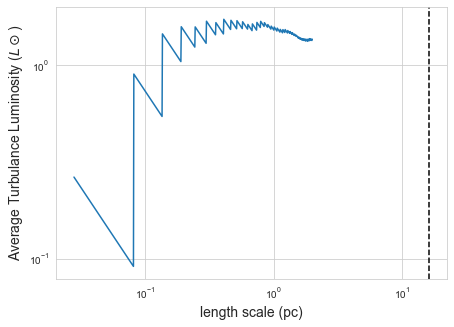

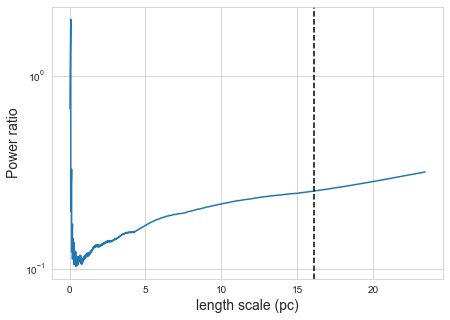

In [71]:
plt.figure(figsize=(7,5))
plt.plot(np.array(length)[np.array(length)<2], np.array(Lum_turb)[np.array(length)<2]/84)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('length scale (pc)', fontsize=14)
plt.ylabel('Average Turbulance Luminosity ($L\odot$)', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
plt.show()
plt.close()

plt.figure(figsize=(7,5))
plt.plot(np.array(length), np.array(power))
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('length scale (pc)', fontsize=14)
plt.ylabel('Power ratio', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
#plt.savefig(filepath + '/output/power_ratio_length.pdf')
plt.show()
plt.close()

In [ ]:
length = []
Lum_turb = []
power = []

Lum_mech_tot = outflowsF['L_mech'].nansum()
length.append(L.value)
Lum_turb.append(lum_cloud.value)
power.append(Lum_mech_tot/lum_cloud)

plt.figure(figsize=(7,5))
plt.scatter(np.array(length), np.array(Lum_turb)/84)
plt.xlabel('legth scale (kpc)', fontsize=14)
plt.ylabel('Average Turbulance Luminosity ($L\odot$)', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
plt.savefig(filepath + '/output/turb_lum_length.pdf') 
plt.close()
plt.figure(figsize=(7,5))
plt.scatter(np.array(length), np.array(power))
plt.xlabel('legth scale (kpc)', fontsize=14)
plt.ylabel('Power ratio', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
plt.savefig(filepath + '/output/power_ratio_length.pdf') 
plt.show
plt.close()

In [23]:
# power vs length curve should flattenn at length = length_crit
length_crit = (((((cygX0.shape[1]*cygX0.shape[2]/84)**0.5) * (cdelt[0] * u.deg)).to(u.rad)) /(1*u.rad)).to(u.dimensionless_unscaled) * np.median(outflows['Distance'])
length_crit

<Quantity 0.01611052 kpc>

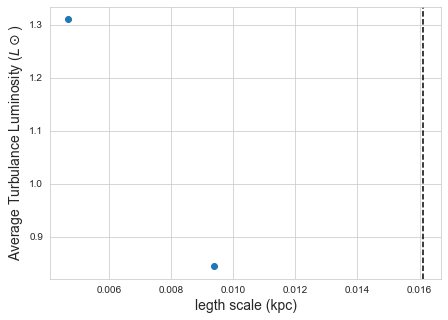

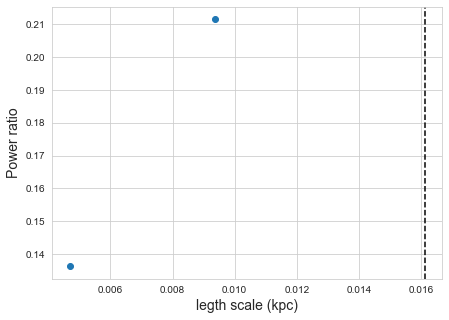

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(np.array(length), np.array(Lum_turb)/84)
plt.xlabel('legth scale (kpc)', fontsize=14)
plt.ylabel('Average Turbulance Luminosity ($L\odot$)', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
plt.show()
plt.close()
plt.figure(figsize=(7,5))
plt.scatter(np.array(length), np.array(power))
plt.xlabel('legth scale (kpc)', fontsize=14)
plt.ylabel('Power ratio', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
plt.show()
plt.close()

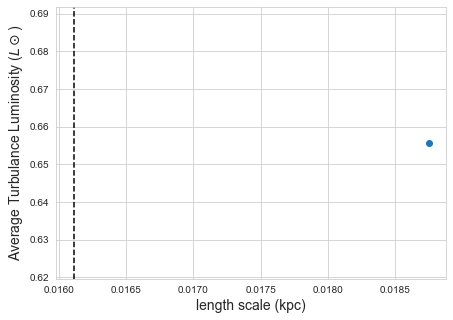

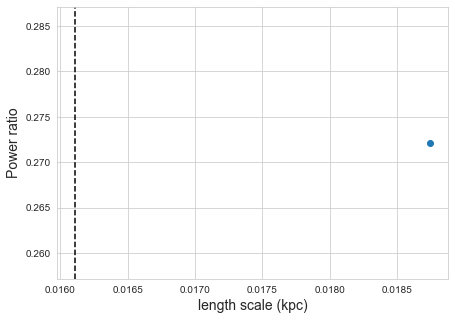

In [24]:
length = []
Lum_turb = []
power = []

Lum_mech_tot = outflowsF['L_mech'].nansum()
length.append(L.value)
Lum_turb.append(lum_cloud.value)
power.append(Lum_mech_tot/lum_cloud)

plt.figure(figsize=(7,5))
plt.scatter(np.array(length), np.array(Lum_turb)/84)
plt.xlabel('length scale (kpc)', fontsize=14)
plt.ylabel('Average Turbulance Luminosity ($L\odot$)', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
plt.show()
plt.close()
plt.figure(figsize=(7,5))
plt.scatter(np.array(length), np.array(power))
plt.xlabel('length scale (kpc)', fontsize=14)
plt.ylabel('Power ratio', fontsize=14)
plt.axvline(x=length_crit.value,color='k', linestyle='--')
plt.show()
plt.close()

In [ ]:
  / 84 ) / (lum_cloud/84)

In [ ]:

power, length

([<Quantity 0.13622754>], [0.004686572])

In [ ]:
cloudshape_ = cygX0[0].shape
angle_ = (cloudshape_[0] * (cdelt[0] * u.deg)).to(u.arcmin)
L_ = (((cloudshape_[0] * (cdelt[0] * u.deg)).to(u.rad)) /(1*u.rad)).to(u.dimensionless_unscaled) * np.median(outflows['Distance'])     #<<<<<<<<<<< size of cloud <<<<<<<<<<<<<<<<<<<<<<<<<<<<<

#cloud, cygX0_masked, cygX0

(SpectralCube with shape=(171, 2966, 2471):
  n_x:   2471  type_x: RA---TAN  unit_x: deg    range:   304.157172 deg:  311.481944 deg
  n_y:   2966  type_y: DEC--TAN  unit_y: deg    range:    39.256583 deg:   45.458596 deg
  n_s:    171  type_s: VOPT      unit_s: km / s  range:      -30.985 km / s:      40.985 km / s,
 SpectralCube with shape=(171, 2966, 2471):
  n_x:   2471  type_x: RA---TAN  unit_x: deg    range:   304.157172 deg:  311.481944 deg
  n_y:   2966  type_y: DEC--TAN  unit_y: deg    range:    39.256583 deg:   45.458596 deg
  n_s:    171  type_s: VOPT      unit_s: m / s  range:   -30984.751 m / s:   40984.751 m / s)

In [ ]:
L_,angle_,cloudshape_[0]

(<Quantity 0.16177019 kpc>, <Quantity 370.74997627 arcmin>, 2966)

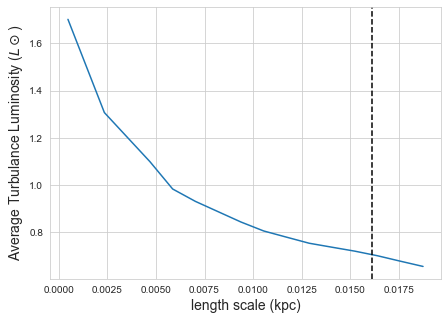

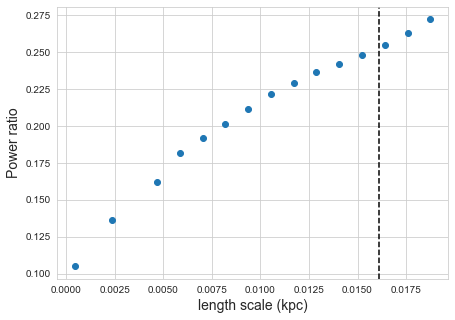

In [105]:
lumarray.nansum()

<Quantity 4089083.14582151 km3 solMass / s3>

INFO: Auto-setting vmin to -2.697e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.547e+01 [aplpy.core]


<Figure size 1296x1152 with 0 Axes>

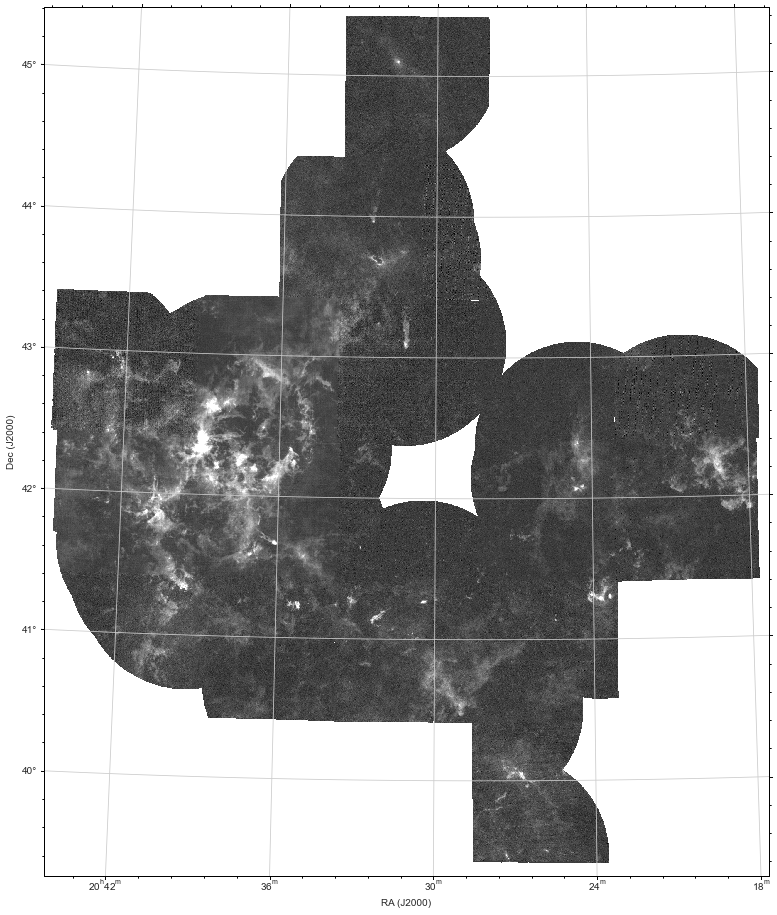

In [87]:
# ALTERNATIVE WAY OF MASKING 
mask2d = cloud_EDT < length_scale_pix

# calculate moment first then apply array mask by suppressing pixels not satisfying mask condition 
cygX0_mom0_along_z = cygX0.moment(order=0, axis=0)  
momarray = np.array(cygX0_mom0_along_z)
momarray[~mask2d] = np.nan

# retrive wcs coordinates and attach to the masked moment:: mommasked = momarray but with wcs 
from spectral_cube import Projection
mommasked = Projection(momarray, wcs = cygX0_mom0_along_z.wcs)

# plot masked moment 
plt.figure(figsize=(18, 16))
f = aplpy.FITSFigure(mommasked.hdu,figsize=(18, 16))
#.show_colorscale()

f.show_grayscale()

In [ ]:
momarray = np.array(cygX0_mom0_along_z)
print(np.nansum(momarray))
momarray[~mask2d] = np.nan
np.nansum(momarray)

25000242.93655903


18732419.284295894

In [ ]:
np.nansum(mommasked)

<Projection 18732419.28429589>


Tpeak_=np.ones(sub_cube_co[0].shape)
vpeak=np.ones(sub_cube_co[0].shape) * u.km/u.s
sigma=np.ones(sub_cube_co[0].shape)
vaxis=sub_cube_co.spectral_axis.value

sub_cube_co = cloud # removes unit=K
Tpeak_ = np.nanmax(sub_cube_co,axis=0)
                
try:
    ai = np.nanargmax(spec, axis=0)
    vpeak = vaxis[ai] * u.km/u.s
except ValueError :
    pass
              
hf = Tpeak_/2

slice_unmasked = sub_cube_co.unmasked_data[:,:,:]  
mask = slice_unmasked > hf

In [ ]:
voff.shape, vcen.shape,vaxis.shape, vcentr.shape, Energy.shape, Mass.shape

((95, 2966, 2471),
 (47, 2966, 2471),
 (95,),
 (2966, 2471),
 (47, 2966, 2471),
 (95, 2966, 2471))

In [ ]:
lum_cloud/84, L

(<Quantity 1.30986527 solLum>, <Quantity 0.00468657 kpc>)

In [ ]:
power_length_scale_modal = pd.read_csv(filepath + '/data/power_length_scale_modal.csv')
power_length_scale_modal['power_ratio'].mean()

0.180034456

In [ ]:
##########################################################################################################################################

In [ ]:
#################################################################################################################################